# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br 

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/469

Instituto de Computação - Unicamp 2022

In [1]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [2]:
train = pd.read_csv('./doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [3]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

C:\Users\kaleb\AppData\Local\Temp\ipykernel_72520\1485874194.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
C:\Users\kaleb\AppData\Local\Temp\ipykernel_72520\1485874194.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()


- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [4]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [5]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

C:\Users\kaleb\AppData\Local\Temp\ipykernel_72520\4148310140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);


,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [6]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

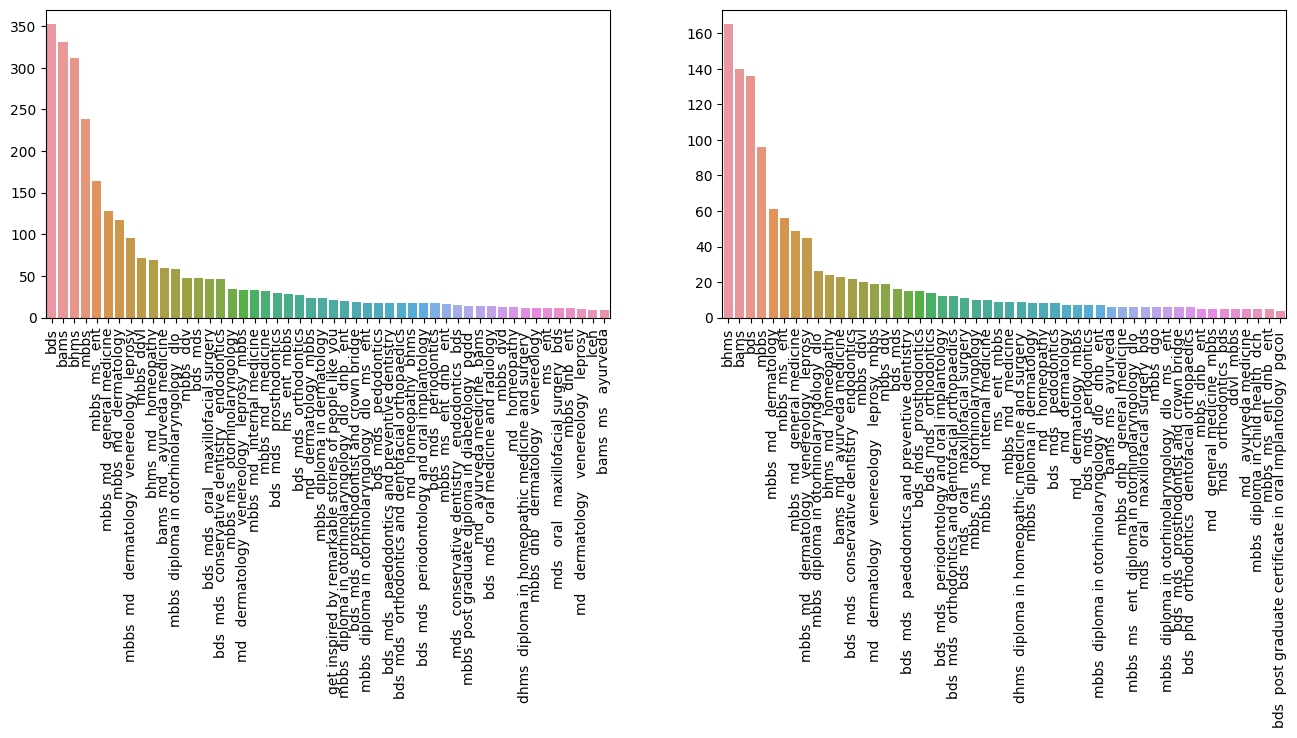

In [7]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

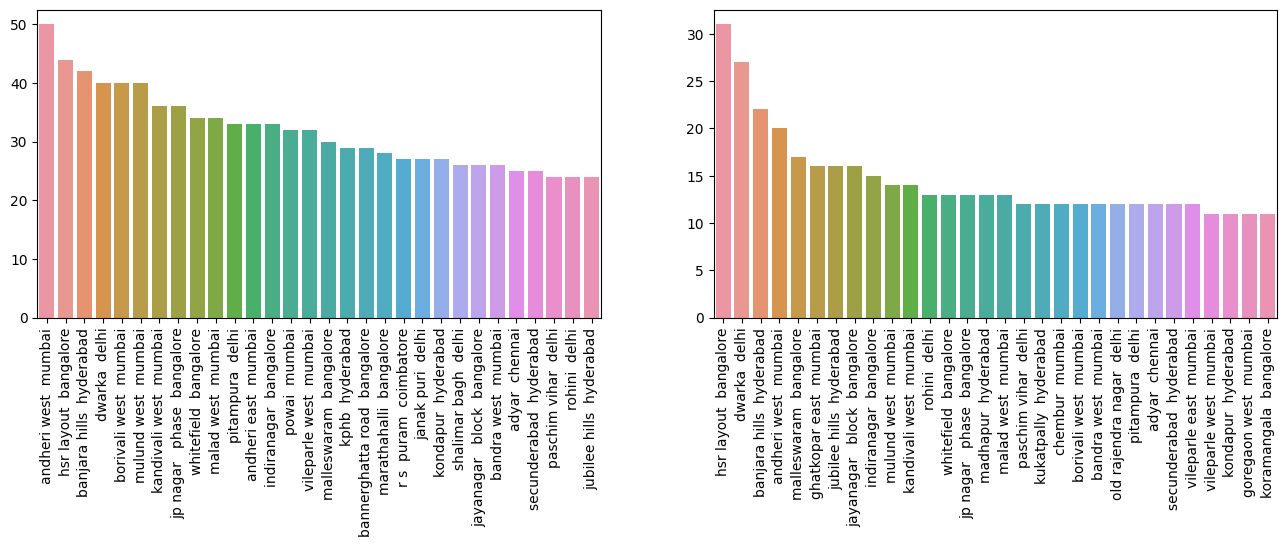

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

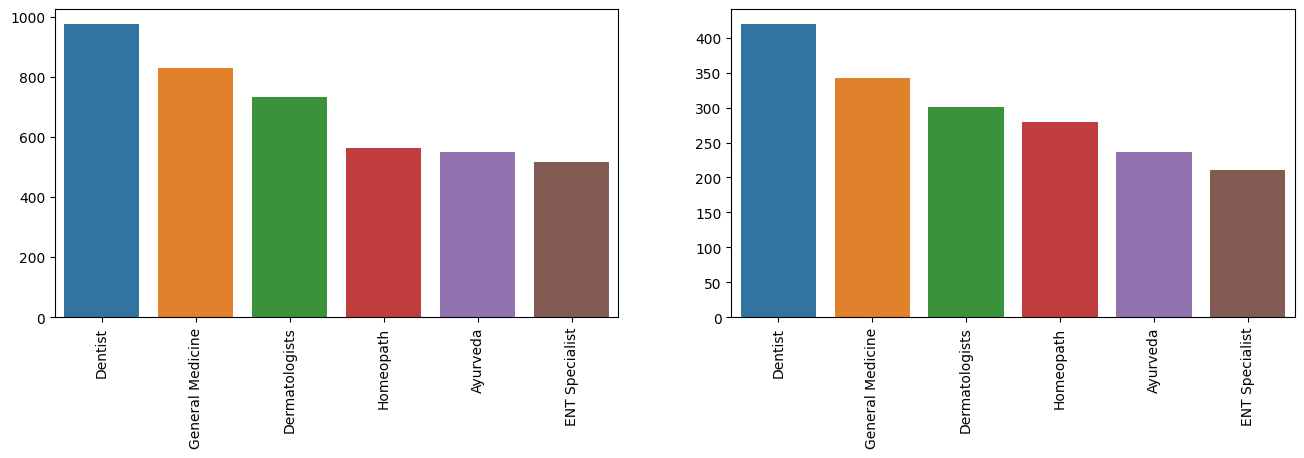

In [9]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [11]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [12]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [13]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no cnjunto de treino. Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaram a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSerach, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [35]:
# Imports
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso

from typing import Tuple, List
import pandas as pd

# Random seed fixed
rs = 1082141
np.random.seed(rs)
sns.set()

In [15]:
# Creating training params
c_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
gamma_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
epsilon_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
kernel_range = ["linear", "rbf", "sigmoid"]
param_grid = dict(C=c_range, gamma=gamma_range, kernel=kernel_range, epsilon=epsilon_range)
cv = KFold(n_splits=5, shuffle=True, random_state=rs)

# Important functions to create customized scorer using MSE for grid search
def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print("MSE: %2.3f" % mse)
    return mse

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print("R2: %2.3f" % r2)
     return r2

def two_score(y_true,y_pred):    
    score = MSE(y_true,y_pred)
    R2(y_true,y_pred) # Just printing R2
    return score

def two_scorer():
    return make_scorer(two_score, greater_is_better=False) # As we use MSE as comparison parameter, greater_is_better = False 

In [16]:
# Applying a grid search (This may take some time, around 20 minutes to run)
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=two_scorer(), verbose=10)
grid.fit(X=train_e, y=ye_train)


Fitting 5 folds for each of 375 candidates, totalling 1875 fits
[CV 1/5; 1/375] START C=0.001, epsilon=0.001, gamma=0.001, kernel=linear........
MSE: 0.946
R2: 0.057
[CV 1/5; 1/375] END C=0.001, epsilon=0.001, gamma=0.001, kernel=linear;, score=-0.946 total time=   0.6s
[CV 2/5; 1/375] START C=0.001, epsilon=0.001, gamma=0.001, kernel=linear........
MSE: 0.912
R2: 0.033
[CV 2/5; 1/375] END C=0.001, epsilon=0.001, gamma=0.001, kernel=linear;, score=-0.912 total time=   0.5s
[CV 3/5; 1/375] START C=0.001, epsilon=0.001, gamma=0.001, kernel=linear........
MSE: 1.032
R2: 0.031
[CV 3/5; 1/375] END C=0.001, epsilon=0.001, gamma=0.001, kernel=linear;, score=-1.032 total time=   0.5s
[CV 4/5; 1/375] START C=0.001, epsilon=0.001, gamma=0.001, kernel=linear........
MSE: 0.911
R2: 0.046
[CV 4/5; 1/375] END C=0.001, epsilon=0.001, gamma=0.001, kernel=linear;, score=-0.911 total time=   0.5s
[CV 5/5; 1/375] START C=0.001, epsilon=0.001, gamma=0.001, kernel=linear........
MSE: 0.974
R2: 0.055
[CV 5/

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring=make_scorer(two_score, greater_is_better=False),
             verbose=10)

In [17]:
# Sorting classifiers by MSE quality
results_svr_grid = pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_score'])
results_svr_grid.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
262,0.565685,0.021196,0.084893,0.020348,1.0,0.1,0.1,rbf,"{'C': 1.0, 'epsilon': 0.1, 'gamma': 0.1, 'kern...",-0.816045,-0.788311,-0.903075,-0.819844,-0.877652,-0.840985,0.042528,1
247,0.578906,0.040441,0.083169,0.004743,1.0,0.01,0.1,rbf,"{'C': 1.0, 'epsilon': 0.01, 'gamma': 0.1, 'ker...",-0.817330,-0.790527,-0.905480,-0.822735,-0.881914,-0.843597,0.042987,2


In [18]:
# Function to retrain the top N best models and apply it to the test set
def get_test_set_results_svr(r_svr_grid: pd.DataFrame, top = 3) -> Tuple[List, List]:
    """
    :param: r_svr_grid: DataFrame result from GridSearchCV
    :param: top: How many results do we wanna do it

    Function that retrain an SVR with given parameters, apply it to the test set and
    :return: a Tuple with the params, and the MSE results for those params in the test set
    """
    all_params = []
    test_set_results = []

    for k in range(0, top):
        curr_params = r_svr_grid["params"].iloc[k]

        print(f"Retraining SVR with {curr_params} and applying it to the test set:")
        svr = SVR(kernel=curr_params["kernel"], 
                  gamma=curr_params["gamma"], 
                  epsilon=curr_params["epsilon"],
                  C=curr_params["C"]
                  )
        svr.fit(X=train_e, y=ye_train)
        ye_pred = svr.predict(X=test_e)
        mse = mean_squared_error(y_true=ye_test, y_pred=ye_pred)
        r2 = r2_score(y_true=ye_test, y_pred=ye_pred)
        print(f"MSE TEST SET = {mse}")
        print(f"R2 TEST SET = {r2}")
        test_set_results.append(mse)
        all_params.append(curr_params)
    
    return all_params, test_set_results
                  
best_params, test_set_mse = get_test_set_results_svr(r_svr_grid=results_svr_grid, top=1)

Retraining SVR with {'C': 1.0, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'} and applying it to the test set:
MSE TEST SET = 0.7977759820018456
R2 TEST SET = 0.2052279675673948


Sabemos que o modelo de SVR *(Support Vector Regression)* representa o *approach* da SVM para modelos de regresssão. O C, assim como na SVM, representa o parâmetro de regularização, se mostrando como a razão entre a classificação do treinamento e a maximização da margem de separação do conjunto de dados. Com valores reduzidos de C, maximizamos a margem, gerando *underfitting*. No caso de valores muito altos, os hiperplanos de separação se tornam complicados e se adequam melhor ao conjunto de dados vigente, o que pode gerar o fenômeno de *overfitting*.
# DISCUTIR

**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [19]:
# Applying a simple linear regression and veryifing it in the TEST SET
lr = LinearRegression().fit(X=train_e, y=ye_train)
y_test_pred = lr.predict(X=test_e)
test_mse_lr = mean_squared_error(y_true=ye_test, y_pred=y_test_pred)
test_r2_lr = r2_score(y_true=ye_test, y_pred=y_test_pred)
print(f"MSE TEST SET = {test_mse_lr}")
print(f"R2 TEST SET = {test_r2_lr}")

MSE TEST SET = 0.8273588126306214
R2 TEST SET = 0.17575652827319055


In [20]:
# Applying a Lasso ridge regression
alpha_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
param_grid_lasso = dict(alpha=alpha_range)
lasso_r = Lasso(alpha=0.1)

# Applying a grid search for Lasso
grid_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=cv, scoring=two_scorer(), verbose=10)
grid_lasso.fit(X=train_e, y=ye_train)

# Sorting classifiers by MSE quality
results_lasso_grid = pd.DataFrame(grid_lasso.cv_results_).sort_values(by=['rank_test_score'])
results_lasso_grid.head(1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START alpha=0.001.................................................
MSE: 0.804
R2: 0.198
[CV 1/5; 1/5] END .................alpha=0.001;, score=-0.804 total time=   0.0s
[CV 2/5; 1/5] START alpha=0.001.................................................
MSE: 0.788
R2: 0.164
[CV 2/5; 1/5] END .................alpha=0.001;, score=-0.788 total time=   0.0s
[CV 3/5; 1/5] START alpha=0.001.................................................
MSE: 0.903
R2: 0.152
[CV 3/5; 1/5] END .................alpha=0.001;, score=-0.903 total time=   0.0s
[CV 4/5; 1/5] START alpha=0.001.................................................
MSE: 0.817
R2: 0.144
[CV 4/5; 1/5] END .................alpha=0.001;, score=-0.817 total time=   0.0s
[CV 5/5; 1/5] START alpha=0.001.................................................
MSE: 0.880
R2: 0.146
[CV 5/5; 1/5] END .................alpha=0.001;, score=-0.880 total time=   0.0s
[CV 1/5; 2/5] START alpha

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025328,0.002329,0.000802,0.000401,0.001,{'alpha': 0.001},-0.804106,-0.787998,-0.903258,-0.817306,-0.879729,-0.83848,0.044891,1


In [21]:
# Retraining and erifying the best lasso in the test set 
best_params = results_lasso_grid["params"].iloc[0]
lasso = Lasso(alpha=best_params["alpha"]).fit(X=train_e, y=ye_train)
y_lasso_test_pred = lasso.predict(X=test_e)
test_lasso_mse_lr = mean_squared_error(y_true=ye_test, y_pred=y_lasso_test_pred)
test_lasso_r2_lr = r2_score(y_true=ye_test, y_pred=y_lasso_test_pred)
print(f"MSE TEST SET = {test_lasso_mse_lr}")
print(f"R2 TEST SET = {test_lasso_r2_lr}")

MSE TEST SET = 0.8068703283494579
R2 TEST SET = 0.19616786511582573


# DISCUTIR

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [51]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 256 primeiras amostras no conjunto de treinamento

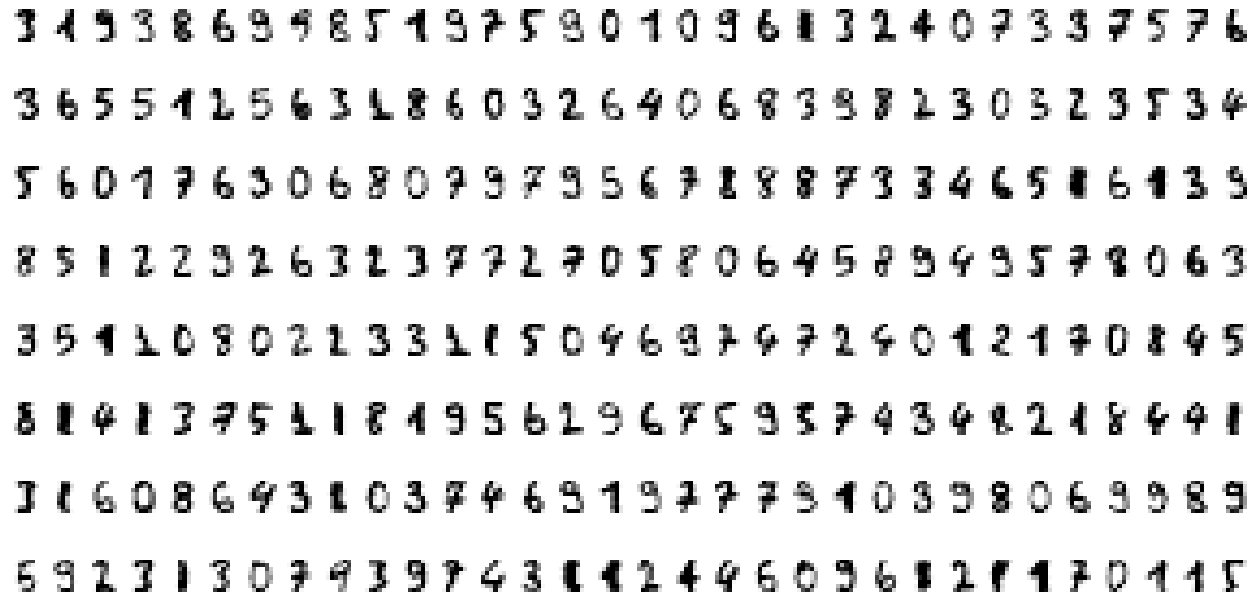

In [52]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

c:\Users\kaleb\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\kaleb\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\kaleb\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\kaleb\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


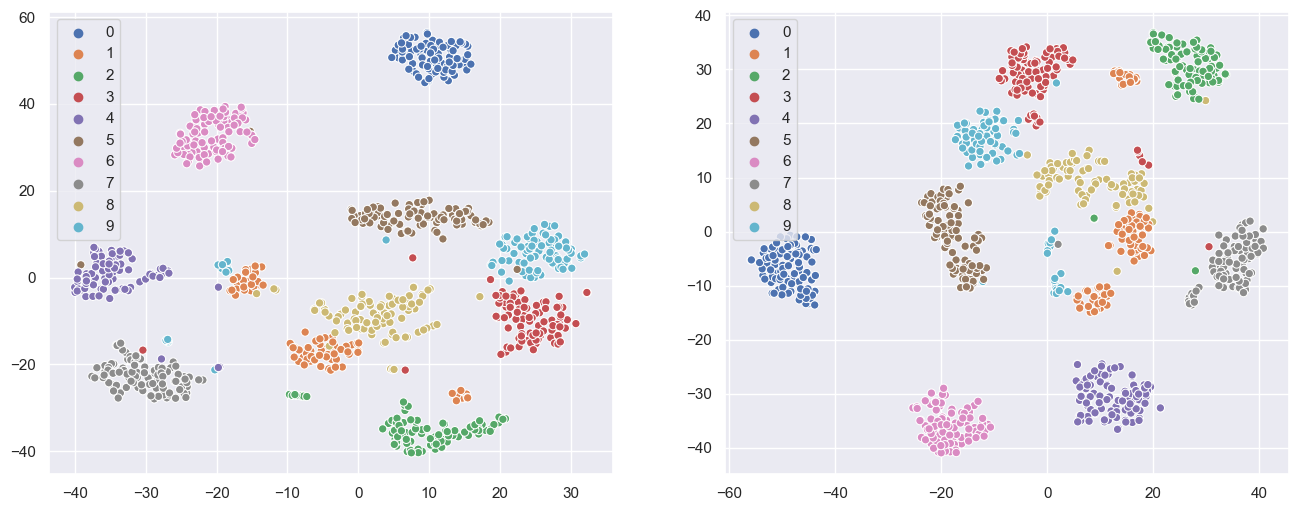

In [53]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

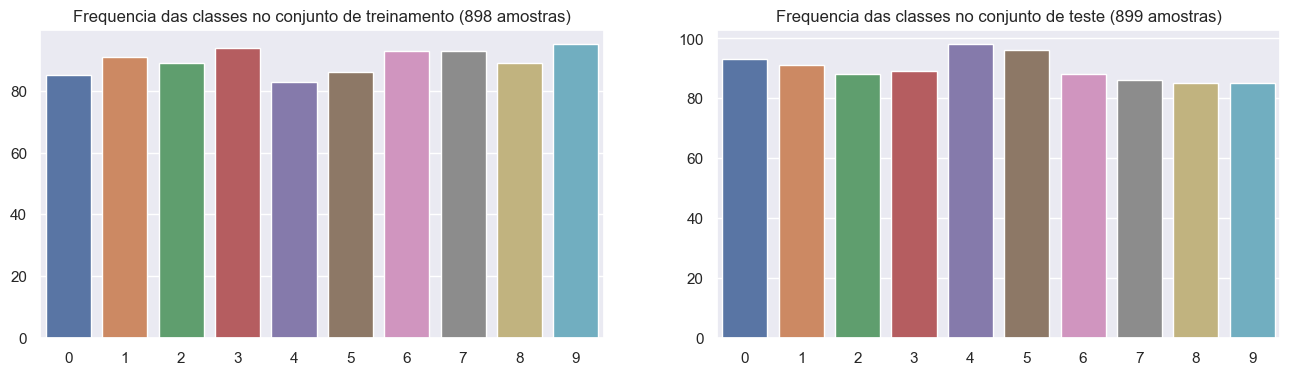

In [54]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

In [55]:
# imports
from sklearn import svm
from sklearn import metrics

In [56]:
# Creating training params
c_range = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 500, 1e3]
param_grid = dict(C=c_range)
cv = KFold(n_splits=10, shuffle=True, random_state=rs)

# Scaling the training and test data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [57]:
# Applying a grid search (This may take some time, around 20 minutes to run)
grid_digits = GridSearchCV(svm.SVC(kernel="linear"), param_grid, cv=cv, scoring="accuracy", verbose=10)
grid_digits.fit(X=x_train, y=y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV 1/10; 1/14] START C=0.0001..................................................
[CV 1/10; 1/14] END ...................C=0.0001;, score=0.156 total time=   0.0s
[CV 2/10; 1/14] START C=0.0001..................................................
[CV 2/10; 1/14] END ...................C=0.0001;, score=0.078 total time=   0.0s
[CV 3/10; 1/14] START C=0.0001..................................................
[CV 3/10; 1/14] END ...................C=0.0001;, score=0.222 total time=   0.0s
[CV 4/10; 1/14] START C=0.0001..................................................
[CV 4/10; 1/14] END ...................C=0.0001;, score=0.178 total time=   0.0s
[CV 5/10; 1/14] START C=0.0001..................................................
[CV 5/10; 1/14] END ...................C=0.0001;, score=0.067 total time=   0.0s
[CV 6/10; 1/14] START C=0.0001..................................................
[CV 6/10; 1/14] END ...................C=0.000

GridSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
             estimator=SVC(kernel='linear'),
             param_grid={'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0,
                               5.0, 10.0, 50.0, 100.0, 500, 1000.0]},
             scoring='accuracy', verbose=10)

In [58]:
# Sorting classifiers by MSE quality
results_svm_grid = pd.DataFrame(grid_digits.cv_results_).sort_values(by=['rank_test_score'])

best_c = results_svm_grid.head(1)["param_C"].iloc[0]
mean_best_acc = results_svm_grid.head(1)["mean_test_score"].iloc[0]
print(f"The best result for the training set using CV = 10 is C = {best_c} with mean accuracy = {mean_best_acc}")

The best result for the training set using CV = 10 is C = 0.5 with mean accuracy = 0.9788139825218478


### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

The accuracy of the best SVM model for the test set is 0.9699666295884316


Text(0.5, 1.0, 'Confusion Matrix')

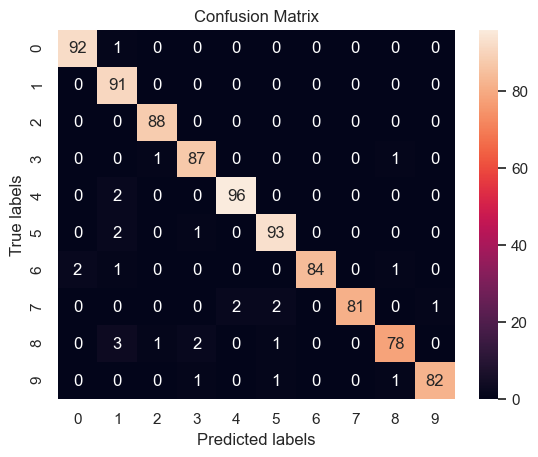

In [59]:
best_svm_lin = svm.SVC(kernel="linear", C=best_c)
best_svm_lin.fit(X=x_train, y=y_train)

# Applying prediction to test set
y_pred_test = best_svm_lin.predict(x_test)


# Applying accuracy and precision
acc_best_svm_lin_test = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
print(f"The accuracy of the best SVM model for the test set is {acc_best_svm_lin_test}")

# Confusion matrix
cm_best_svm_lin_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test)
ax= plt.subplot()
sns.heatmap(cm_best_svm_lin_test, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

In [60]:
c_range = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 500, 1e3]
gamma_range = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 500, 1e3]
param_grid = dict(C=c_range, gamma=gamma_range)
cv = KFold(n_splits=10, shuffle=True, random_state=rs)

# Applying a grid search (This may take some time, around 20 minutes to run)
grid_digits_rbf = GridSearchCV(svm.SVC(kernel="rbf"), param_grid, cv=cv, scoring="accuracy", verbose=10)
grid_digits_rbf.fit(X=x_train, y=y_train)

Fitting 10 folds for each of 196 candidates, totalling 1960 fits
[CV 1/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 1/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.156 total time=   0.0s
[CV 2/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 2/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.078 total time=   0.0s
[CV 3/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 3/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.222 total time=   0.0s
[CV 4/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 4/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.178 total time=   0.0s
[CV 5/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 5/10; 1/196] END ....C=0.0001, gamma=0.0001;, score=0.067 total time=   0.0s
[CV 6/10; 1/196] START C=0.0001, gamma=0.0001...................................
[CV 6/10; 1/196] END ....C=0.0001, gamma=0.0

GridSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0,
                               5.0, 10.0, 50.0, 100.0, 500, 1000.0],
                         'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,
                                   1.0, 5.0, 10.0, 50.0, 100.0, 500, 1000.0]},
             scoring='accuracy', verbose=10)

In [61]:
# Sorting classifiers by MSE quality
results_svm_rbf_grid = pd.DataFrame(grid_digits_rbf.cv_results_).sort_values(by=['rank_test_score'])

best_c_rbf = results_svm_rbf_grid.head(1)["param_C"].iloc[0]
best_gamma_rbf = results_svm_rbf_grid.head(1)["param_gamma"].iloc[0]
mean_best_acc_rbf = results_svm_rbf_grid.head(1)["mean_test_score"].iloc[0]
print(f"The best result for the training set using CV = 10 is C = {best_c_rbf} and gamma = {best_gamma_rbf} with mean accuracy = {mean_best_acc_rbf}")

The best result for the training set using CV = 10 is C = 1000.0 and gamma = 0.0001 with mean accuracy = 0.9799500624219725


**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

In [62]:
c_range = [1e-5, 3e-5, 5e-5, 7e-5, 1e-4, 3e-4, 5e-4, 6e-4, 1e-3, 3e-3, 5e-3, 7e-3, 1e-2, 3e-2, 5e-2, 7e-2, 1e-1, 3e-1, 5e-1, 7e-1, 1e0, 3e0, 5e0, 7e0, 1e1, 3e-1, 5e1, 7e1, 1e2, 3e2, 5e2, 7e2, 1e3, 3e3, 5e3, 7e3, 1e4, 5e4]
gamma_range = [1e-5, 3e-5, 5e-5, 7e-5, 1e-4, 3e-4, 5e-4, 6e-4, 1e-3, 3e-3, 5e-3, 7e-3, 1e-2, 3e-2, 5e-2, 7e-2, 1e-1, 3e-1, 5e-1, 7e-1, 1e0, 3e0, 5e0, 7e0, 1e1, 3e-1, 5e1, 7e1, 1e2, 3e2, 5e2, 7e2, 1e3, 3e3, 5e3, 7e3, 1e4, 5e4]
param_grid = dict(C=c_range, gamma=gamma_range)

random_search_digits_rbf = RandomizedSearchCV(svm.SVC(kernel="rbf"), param_grid, cv=cv, scoring="accuracy", n_iter=100, random_state=rs, verbose=10)
random_search_digits_rbf.fit(X=x_train, y=y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 1/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=0.967 total time=   0.0s
[CV 2/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 2/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=0.956 total time=   0.0s
[CV 3/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 3/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=1.000 total time=   0.0s
[CV 4/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 4/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=0.978 total time=   0.0s
[CV 5/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 5/10; 1/100] END .....C=3000.0, gamma=7e-05;, score=1.000 total time=   0.0s
[CV 6/10; 1/100] START C=3000.0, gamma=7e-05....................................
[CV 6/10; 1/100] END .....C=3000.0, gamma=7e

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
                   estimator=SVC(), n_iter=100,
                   param_distributions={'C': [1e-05, 3e-05, 5e-05, 7e-05,
                                              0.0001, 0.0003, 0.0005, 0.0006,
                                              0.001, 0.003, 0.005, 0.007, 0.01,
                                              0.03, 0.05, 0.07, 0.1, 0.3, 0.5,
                                              0.7, 1.0, 3.0, 5.0, 7.0, 10.0,
                                              0.3, 50.0, 70.0, 100.0, 300.0, ...],
                                        'gamma': [1e-05, 3e-05, 5e-05, 7e-05,
                                                  0.0001, 0.0003, 0.0005,
                                                  0.0006, 0.001, 0.003, 0.005,
                                                  0.007, 0.01, 0.03, 0.05, 0.07,
                                                  0.1, 0.3, 0.5, 0.7, 1.0, 3.0,
                                                  5.0, 7.0, 10.0, 0.3, 50.0,
                                                  70.0, 100.0, 300.0, ...]},
                   random_state=1082141, scoring='accuracy', verbose=10)

In [63]:
# Sorting classifiers by MSE quality
results_svm_rbf_random_search = pd.DataFrame(random_search_digits_rbf.cv_results_).sort_values(by=['rank_test_score'])

best_c_rbf_random_search = results_svm_rbf_random_search.head(1)["param_C"].iloc[0]
best_gamma_rbf_random_search = results_svm_rbf_random_search.head(1)["param_gamma"].iloc[0]
mean_best_acc_rbf_random_search = results_svm_rbf_random_search.head(1)["mean_test_score"].iloc[0]
print(f"The best result for the training set using CV = 10 is C = {best_c_rbf_random_search} and gamma = {best_gamma_rbf_random_search} with mean accuracy = {mean_best_acc_rbf_random_search}")

The best result for the training set using CV = 10 is C = 7000.0 and gamma = 1e-05 with mean accuracy = 0.9810486891385768


### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

The accuracy of the best SVM RBF model with GridSearch for the test set is 0.9710789766407119


Text(0.5, 1.0, 'Confusion Matrix')

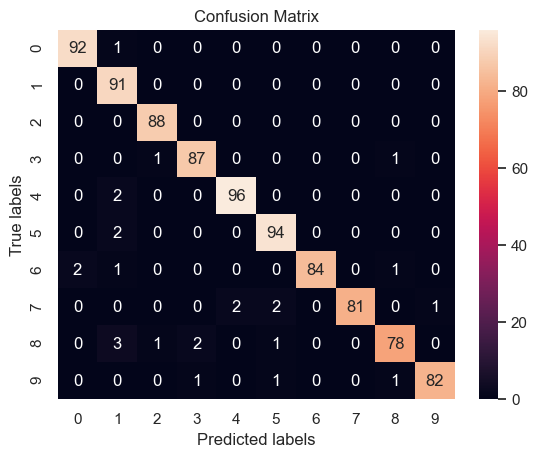

In [65]:
# Best model GridSearch for RBF
best_svm_rbf_grid = svm.SVC(kernel="rbf", C=best_c_rbf, gamma=best_gamma_rbf)
best_svm_rbf_grid.fit(X=x_train, y=y_train)

# Applying prediction to test set
y_pred_test_rbf = best_svm_rbf_grid.predict(x_test)


# Applying accuracy and precision
acc_best_svm_rbf_test = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test_rbf)
print(f"The accuracy of the best SVM RBF model with GridSearch for the test set is {acc_best_svm_rbf_test}")

# Confusion matrix
cm_best_svm_rbf_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test_rbf)
ax= plt.subplot()
sns.heatmap(cm_best_svm_rbf_test, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')


The accuracy of the best SVM RBF model with RandomSearch for the test set is 0.9721913236929922


Text(0.5, 1.0, 'Confusion Matrix')

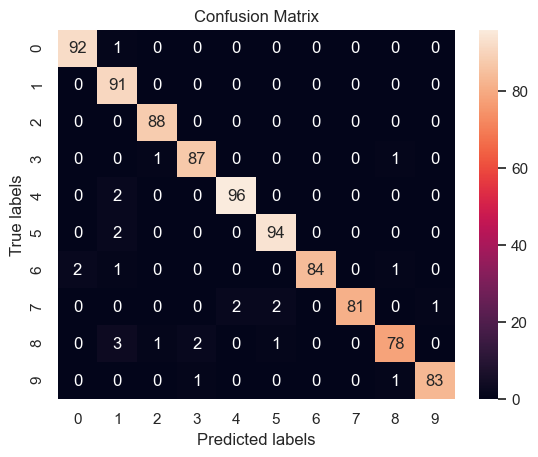

In [66]:
# Best model Random for RBF
best_svm_rbf_random_search = svm.SVC(kernel="rbf", C=best_c_rbf_random_search, gamma=best_gamma_rbf_random_search)
best_svm_rbf_random_search.fit(X=x_train, y=y_train)

# Applying prediction to test set
y_pred_test_rbf_random_search = best_svm_rbf_random_search.predict(x_test)


# Applying accuracy and precision
acc_best_svm_rbf_test_random_search = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test_rbf_random_search)
print(f"The accuracy of the best SVM RBF model with RandomSearch for the test set is {acc_best_svm_rbf_test_random_search}")

# Confusion matrix
cm_best_svm_rbf_test_random_search = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test_rbf_random_search)
ax= plt.subplot()
sns.heatmap(cm_best_svm_rbf_test_random_search, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')